# 80年代末 最有名的卷积神经网络 LeNet

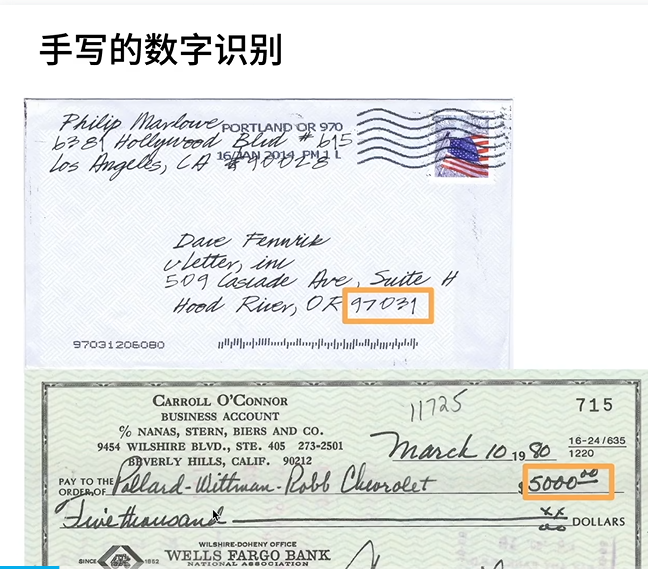

# LeNet提出所附带的数据集
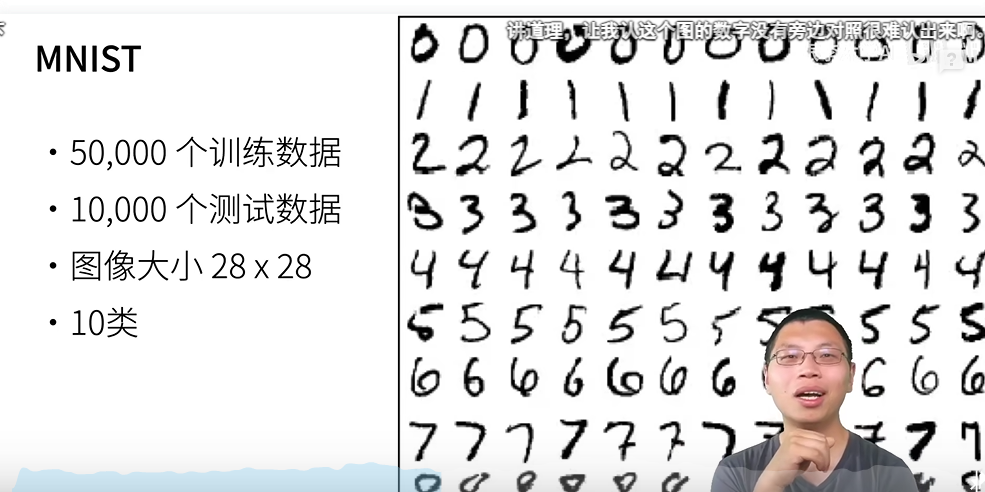


当年由该数据集得到的demo
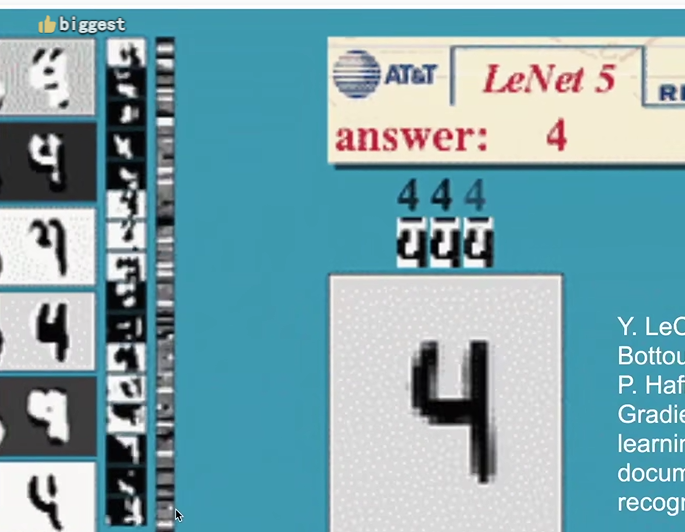

# LeNet流程图

1.卷积层
2.池化层
3.卷积层
4.池化层
5.全连接层
6.全连接层
7.输出层

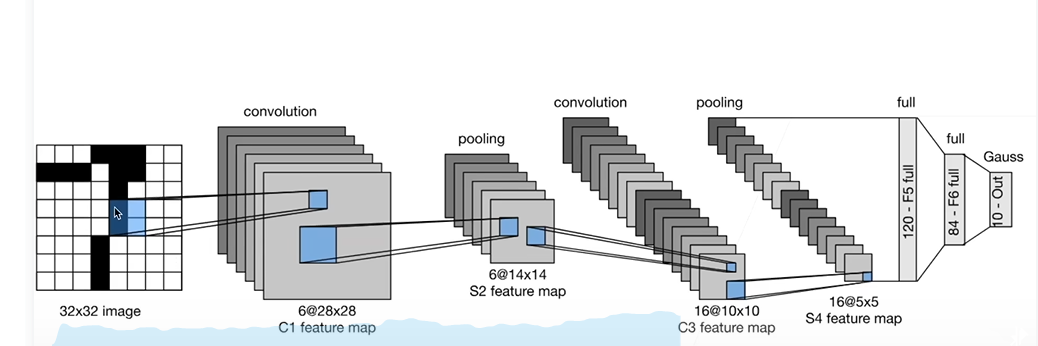

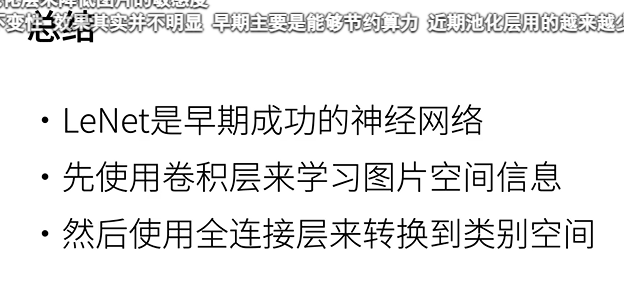

# 代码

In [26]:
import torch
from torch import nn
from d2l import torch as d2l

# 定义一个自定义的层，用于将输入的形状调整为(-1, 1, 28, 28)
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

# -1表示批量大小是动态的 会根据输入数据实际量自动确认
# 1 表示通道数量
# 28核28为图像长宽
    
# 定义一个顺序容器，将各层按顺序添加到网络中
net = torch.nn.Sequential(
    Reshape(),  # 将输入的形状调整为 (批量大小, 通道数, 高度, 宽度)，即 (-1, 1, 28, 28)
    
    # 第一层卷积层
    nn.Conv2d(1, 6, kernel_size=5, padding=2),  # 输入通道数为1，输出通道数为6，
    #卷积核大小为5x5，填充为2
    nn.Sigmoid(),  # 激活函数为Sigmoid
    
    # 第一层池化层
    nn.AvgPool2d(kernel_size=2, stride=2),  # 平均池化层，池化窗口大小为2x2，步幅为2
    
    # 第二层卷积层
    nn.Conv2d(6, 16, kernel_size=5),  # 输入通道数为6，输出通道数为16，卷积核大小为5x5
    nn.Sigmoid(),  # 激活函数为Sigmoid
    
    # 第二层池化层
    nn.AvgPool2d(kernel_size=2, stride=2),  # 平均池化层，池化窗口大小为2x2，步幅为2
    
    # 将多维的卷积层输出展开成一维的向量
    nn.Flatten(),  
    # 将 (批量大小, 通道数, 高度, 宽度) 展平为 (批量大小, 通道数*高度*宽度)
    
    # 第一层全连接层
    nn.Linear(16 * 5 * 5, 120),  # 输入维度为16*5*5（即卷积层输出展平后的大小）
    #输出维度为120
    nn.Sigmoid(),  # 激活函数为Sigmoid
    
    # 第二层全连接层
    nn.Linear(120, 84),  # 输入维度为120，输出维度为84
    nn.Sigmoid(),  # 激活函数为Sigmoid
    
    # 第三层全连接层
    nn.Linear(84, 10)  # 输入维度为84，输出维度为10（即分类的类别数）
)


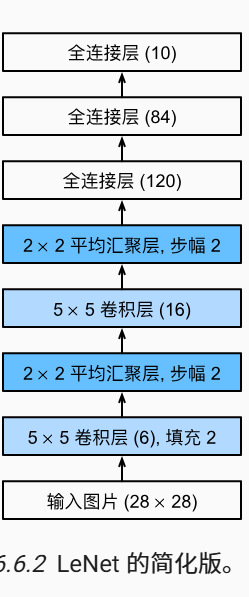

In [27]:
#测试一下模型

# 创建一个形状为 (1, 1, 28, 28) 的随机张量，表示一张灰度图像
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
# 逐层传递输入数据，并打印每层的输出形状
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)
    
#各个参数 批量大小 通道数 长度 宽度
X

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


tensor([[-0.0152,  0.2025, -0.0773, -0.5571,  0.4125,  0.1620,  0.2206,  0.3339,
         -0.0112, -0.2462]], grad_fn=<AddmmBackward0>)

In [32]:
#LeNet，让我们看看LeNet在Fashion-MNIST数据集上的表现。

batch_size = 256

#将数据分为训练数据 核 测试数据

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [33]:
# 定义用GPU训练模型的函数
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    
    # 初始化模型权重的函数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    
    # 将初始化权重的函数应用到模型
    net.apply(init_weights)
    print('training on', device)
    
    # 将模型移动到指定设备（GPU或CPU）
    net.to(device)
    
    # 定义优化器，使用随机梯度下降（SGD）
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    # 定义损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    
    # 创建动画器，用于可视化训练过程
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    
    # 计时器和训练批次数量
    timer, num_batches = d2l.Timer(), len(train_iter)
    
    # 开始训练过程
    for epoch in range(num_epochs):
        # 初始化度量器，用于累加损失和准确性
        metric = d2l.Accumulator(3)
        net.train()  # 设置模型为训练模式
        
        # 遍历训练数据集
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()  # 清空梯度
            X, y = X.to(device), y.to(device)  # 将数据移动到指定设备
            y_hat = net(X)  # 前向传播
            l = loss(y_hat, y)  # 计算损失
            l.backward()  # 反向传播
            optimizer.step()  # 更新模型参数
            with torch.no_grad():
                # 累加损失、准确性和样本数量
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            
            # 计算训练损失和准确性
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            
            # 每训练一部分数据，更新动画器
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        
        # 在测试集上评估模型
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')    
    # 打印最终的训练损失、训练准确性和测试

loss 0.470, train acc 0.823, test acc 0.822
90396.5 examples/sec on cuda:0


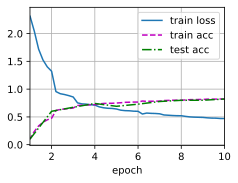

In [34]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

卷积神经网络（CNN）是一类使用卷积层的网络。

在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。

为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。

在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。

LeNet是最早发布的卷积神经网络之一。

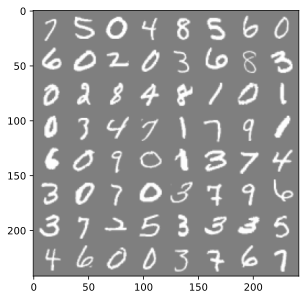

    7     5     0     4     8     5     6     0


In [38]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np  # 添加 NumPy 导入

# 定义数据转换
transform = transforms.Compose([transforms.ToTensor()])

# 下载并加载训练数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 下载并加载测试数据集
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 查看一些训练样本
def imshow(img):
    img = img / 2 + 0.5  # 反标准化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取一些随机的训练图像
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 显示图像和标签
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(8)))